[![preview notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PySDM/blob/main/examples/PySDM_examples/monte_carlo_transport_scheme/simulation_1D.ipynb)
[![launch on mybinder.org](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PySDM.git/main?urlpath=lab/tree/examples/PySDM_examples/monte_carlo_transport_scheme/simulation_1D.ipynb)
[![launch on Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PySDM/blob/main/examples/PySDM_examples/monte_carlo_transport_scheme/simulation_1D.ipynb)

### Simulation of a Monte Carlo Transport Scheme

In [4]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PySDM-examples')

In [5]:
import numpy as np
import matplotlib.pyplot as plt

### One-dimensional test case: soft hat advected by uniform wind

Curtis, J. H., Riemer, N., and West, M.: Explicit stochastic advection algorithms for the regional-scale particle-resolved atmospheric aerosol model WRF-PartMC (v1.0), Geosci. Model Dev., 17, 8399–8420, https://doi.org/10.5194/gmd-17-8399-2024, 2024. 

### Analytic Solution

Simulation Parameters

In [6]:
Nx = 50             # Number of grid cells
x = np.linspace(0, 1, Nx, endpoint=False)  # Grid points
dx = x[1] - x[0]
dt = 0.008          # Time step [s]
T = 2.0             # Total time [s]
Nt = int(T / dt)    # Number of time steps
u = 1.0             # Constant velocity [m/s]
courant = u * dt / dx

Initial condition: Soft-hat profile

In [7]:
def soft_hat(x):
    return 0.5 + 0.5 / (1 + np.exp(80 * (np.abs(x - 0.5) - 0.15)))

n0 = soft_hat(x)

First-order upwind advection scheme

In [8]:
def advect_first_order(n, courant):
    n_new = np.copy(n)
    n_new[1:] = n[1:] - courant * (n[1:] - n[:-1])
    n_new[0] = n[0] - courant * (n[0] - n[-1])  # Periodic BC
    return n_new

Run the simulation using first-order upwind

In [9]:
n = np.copy(n0)
for _ in range(Nt):
    n = advect_first_order(n, courant)

Plot initial and final state

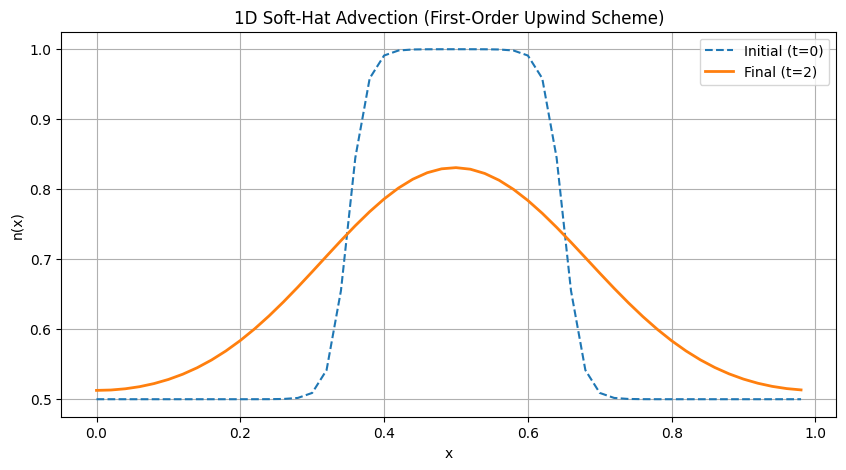

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(x, n0, label='Initial (t=0)', linestyle='--')
plt.plot(x, n, label='Final (t=2)', linewidth=2)
plt.title("1D Soft-Hat Advection (First-Order Upwind Scheme)")
plt.xlabel("x")
plt.ylabel("n(x)")
plt.legend()
plt.grid(True)
plt.show()


### Monte Carlo Solution

In [40]:
from PySDM import Builder, Formulae, products
from PySDM.dynamics import Displacement
from PySDM.backends import CPU
from PySDM.environments import Box
from PySDM.impl.mesh import Mesh

In [41]:
print(x)

[0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26
 0.28 0.3  0.32 0.34 0.36 0.38 0.4  0.42 0.44 0.46 0.48 0.5  0.52 0.54
 0.56 0.58 0.6  0.62 0.64 0.66 0.68 0.7  0.72 0.74 0.76 0.78 0.8  0.82
 0.84 0.86 0.88 0.9  0.92 0.94 0.96 0.98]


In [42]:
x_mesh = Mesh(
  grid=[Nx],           # number of cells in each dimension
  size=[1.0],          # physical size of the domain in each dimension
)

In [43]:
print(x_mesh)

In [44]:
# Initialize the simulation with CPU backend
builder = Builder(
  backend=CPU(),
  n_sd=1,
  environment=Box(dt=dt, dv=0.0)
)
builder.add_dynamic(Displacement(enable_monte_carlo=True, adaptive=False))

In [45]:
initial_positions = x_mesh.get_cell_centers()
# Build particle model
builder.set_position('x', initial_positions)
builder.set('n', soft_hat(initial_positions))
model = builder.build()

# Monte Carlo displacement for advection
displacement = Displacement(enable_monte_carlo=True)

# Time stepping loop
for _ in range(Nt):
    displacement(model, dt=dt, velocity_field={'x': u})

AttributeError: 'Mesh' object has no attribute 'get_cell_centers'